In [33]:
import torch
import torchvision
import lightning as L
import matplotlib.pyplot as plt

from dcgan import DCGAN
from data import CatsDataModule, PATH_DATASETS, NUM_WORKERS, BATCH_SIZE
from vae import VAE
from diffusion import Diffusion
from gan import GAN

torch.cuda.empty_cache()
L.seed_everything(42)
torch.set_float32_matmul_precision("highest")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed set to 42


In [41]:
class DCGAN(DCGAN):
    def test_step(self, batch, batch_idx):
        imgs, _ = batch
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        gen_imgs = self(z)
        real_imgs = (imgs + 1) / 2
        gen_imgs = (gen_imgs + 1) / 2
        self.fid.update(real_imgs, real=True)
        self.fid.update(gen_imgs, real=False)

    def on_test_epoch_end(self):
        fid_score = self.fid.compute()
        self.log("fid_score", fid_score, prog_bar=True)
        self.fid.reset()
        num_examples = 32
        z = torch.randn(num_examples, self.hparams.latent_dim, device=self.device)
        sample_imgs = self(z)
        sample_imgs = (sample_imgs + 1) / 2
        sample_imgs = torch.clamp(sample_imgs, 0, 1)
        grid = torchvision.utils.make_grid(sample_imgs)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        epoch = self.current_epoch
        if self.logger is not None:
            run_id = self.logger.run_id
            self.logger.experiment.log_image(
                image=grid, step=epoch, run_id=run_id, key="test_epoch_img"
            )
        else:
            plt.imshow(grid)
            plt.axis("off")
            plt.title("Test Images")
            plt.show()


# use the same testing logic to VAE and Diffusion models
class VAE(VAE):
    def test_step(self, batch, batch_idx):
        x, _ = batch
        x = x.to(device)
        x_hat, mu, logvar = self(x)
        loss, recon, kld = self.compute_loss(x, x_hat, mu, logvar)
        self.log_dict({"val_loss": loss, "val_recon": recon, "val_kld": kld})

        real = (x + 1) / 2
        fake = (x_hat + 1) / 2
        self.fid.update(real, real=True)
        self.fid.update(fake, real=False)

    def on_test_epoch_end(self):
        fid_score = self.fid.compute()
        self.log("fid_score", fid_score)
        self.fid.reset()

        with torch.no_grad():
            example_z = torch.randn(32, self.hparams.latent_dim).to(self.device)
            samples = self.decoder(example_z)
            samples = (samples + 1) / 2
            grid = torchvision.utils.make_grid(samples)
            grid = grid.permute(1, 2, 0).cpu().numpy()
            plt.imshow(grid)
            plt.axis("off")
            plt.show()


class Diffusion(Diffusion):
    def test_step(self, batch, batch_idx):
        imgs, _ = batch
        real = (imgs + 1) / 2
        x = torch.randn_like(imgs).to(device)
        for i in reversed(range(self.hparams.timesteps)):
            t = torch.full((imgs.size(0),), i, dtype=torch.long, device=device)
            eps = self.model(x, t)
            beta = self.betas[t].view(-1, 1, 1, 1)
            alpha = 1 - beta
            x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha)) * eps)
            if i > 0:
                x = x + torch.sqrt(beta) * torch.randn_like(x)
        gen = torch.clamp(x, 0.0, 1.0)
        self.fid.update(real, real=True)
        self.fid.update(gen, real=False)
        return gen

    def on_test_epoch_end(self):
        fid_score = self.fid.compute()
        self.log("fid_score", fid_score, prog_bar=True)
        self.fid.reset()
        with torch.no_grad():
            x = self.validation_z.clone()
            for i in reversed(range(self.hparams.timesteps)):
                t = torch.full((x.size(0),), i, dtype=torch.long, device=self.device)
                eps = self.model(x, t)
                beta = self.betas[t].view(-1, 1, 1, 1)
                alpha = 1 - beta
                x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha)) * eps)
                if i > 0:
                    x = x + torch.sqrt(beta) * torch.randn_like(x)
            samples = torch.clamp(x, 0.0, 1.0)
        grid = torchvision.utils.make_grid(samples)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        epoch = self.current_epoch
        if self.logger is not None:
            run_id = self.logger.run_id
            self.logger.experiment.log_image(
                image=grid, step=epoch, run_id=run_id, key="test_epoch_img"
            )
        else:
            plt.imshow(grid)
            plt.axis("off")
            plt.title("Test Images")
            plt.show()


class GAN(GAN):
    def test_step(self, batch, batch_idx):
        imgs, _ = batch
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        gen_imgs = self(z)
        real_imgs = (imgs + 1) / 2
        gen_imgs = (gen_imgs + 1) / 2
        self.fid.update(real_imgs, real=True)
        self.fid.update(gen_imgs, real=False)

    def on_test_epoch_end(self):
        fid_score = self.fid.compute()
        self.log("fid_score", fid_score, prog_bar=True)
        self.fid.reset()
        num_examples = 32
        z = torch.randn(num_examples, self.hparams.latent_dim, device=self.device)
        sample_imgs = self(z)
        sample_imgs = (sample_imgs + 1) / 2
        sample_imgs = torch.clamp(sample_imgs, 0, 1)
        grid = torchvision.utils.make_grid(sample_imgs)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        epoch = self.current_epoch
        if self.logger is not None:
            run_id = self.logger.run_id
            self.logger.experiment.log_image(
                image=grid, step=epoch, run_id=run_id, key="test_epoch_img"
            )
        else:
            plt.imshow(grid)
            plt.axis("off")
            plt.title("Test Images")
            plt.show()


data = CatsDataModule(PATH_DATASETS, BATCH_SIZE, NUM_WORKERS)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 24/24 [00:24<00:00,  0.98it/s]

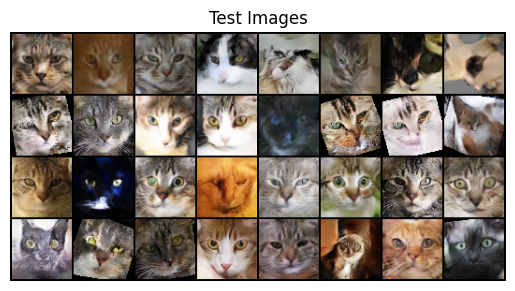

Testing DataLoader 0: 100%|██████████| 24/24 [00:26<00:00,  0.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        fid_score            32.15481948852539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [24]:
checkpoint_path = "../checkpoints/dcgan/dcgan-transforms-epoch=443-d_loss=0.01-g_loss=4.86-fid_score=31.61.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = DCGAN.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
trainer = L.Trainer(
    logger=False,
)
trainer.test(model, datamodule=data)
None

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 24/24 [00:24<00:00,  1.00it/s]

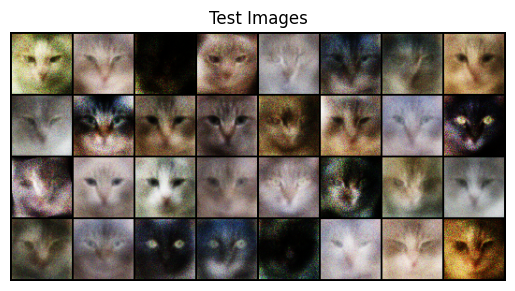

Testing DataLoader 0: 100%|██████████| 24/24 [00:25<00:00,  0.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        fid_score           124.87115478515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [25]:
checkpoint_path = "../checkpoints/gan/gan-transforms-epoch=137-d_loss=0.43-g_loss=1.46-fid_score=123.88.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = GAN.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
trainer = L.Trainer(
    logger=False,
)
trainer.test(model, datamodule=data)
None

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 24/24 [03:05<00:00,  0.13it/s]

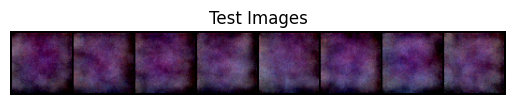

Testing DataLoader 0: 100%|██████████| 24/24 [03:06<00:00,  0.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        fid_score            223.2197723388672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [37]:
checkpoint_path = "../checkpoints/diffusion/diffusion-epoch=11-fid_score=222.25.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = Diffusion.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
trainer = L.Trainer(
    logger=False,
)
trainer.test(model, datamodule=data)
None

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 24/24 [00:24<00:00,  1.00it/s]

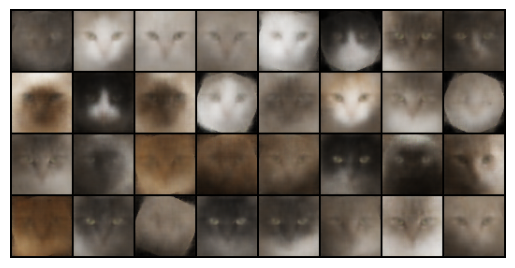

Testing DataLoader 0: 100%|██████████| 24/24 [00:25<00:00,  0.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        fid_score            161.2156982421875
         val_kld           0.036189544945955276
        val_loss            0.15508058667182922
        val_recon           0.11889104545116425
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [42]:
checkpoint_path = "../checkpoints/vae/vae-epoch=49-fid_score=160.62.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = VAE.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
trainer = L.Trainer(
    logger=False,
)
trainer.test(model, datamodule=data)
None

## Dogs and Cats dataset

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 49/49 [00:51<00:00,  0.95it/s]

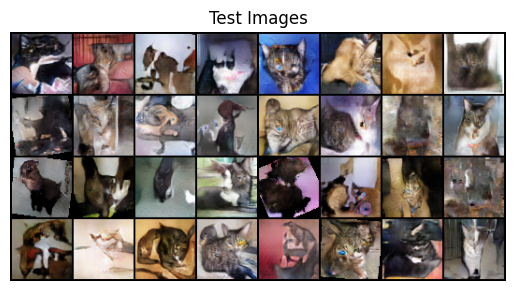

Testing DataLoader 0: 100%|██████████| 49/49 [00:53<00:00,  0.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        fid_score           102.61295318603516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [46]:
from data import CatsDogsDataModule

data = CatsDogsDataModule()
checkpoint_path = "../checkpoints/dcgan-dogscats/dcgan-transforms-dogscats-epoch=476-fid_score=103.44.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = DCGAN.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
trainer = L.Trainer(
    logger=False,
)
trainer.test(model, datamodule=data)
None